# Socrata API Project

This notebook uses the `requests` package and the SODA API to access data through https://data.nashville.gov/.

### Find 2 new data sets on data.nashville.gov, make API requests to pull the data, and do an analysis that combines the data sets.  

##### Import the relevant modules and pull in the API data

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

##### Pull in the siren API

In [2]:
siren_ep = 'https://data.nashville.gov/resource/736j-2drk.json'

siren_params = {
    '$limit':200000 
}

siren_resp = requests.get(siren_ep, params=siren_params)
siren_resp.status_code

200

In [3]:
siren_result = siren_resp.json()
siren_result[0]

{'site_name': 'Ezell Road Park',
 'address': '5135 Harding Place',
 'city': 'Nashville',
 'zip': '37211',
 'siren_power': 'Eclipse 8',
 'location': {'latitude': '36.090944', 'longitude': '-86.686028'},
 ':@computed_region_gisn_y5cm': '7',
 ':@computed_region_sjpq_96s8': '15803',
 ':@computed_region_v3ji_vzam': '2005',
 ':@computed_region_c9xn_skx3': '18',
 ':@computed_region_f73m_vb2k': '9'}

##### Pull in the local event permit API

In [4]:
event_ep = 'https://data.nashville.gov/resource/vygj-v677.json'

event_params = {
    '$limit':200000,
    'event_type':'Public'
}

event_resp = requests.get(event_ep, params=event_params)
event_resp.status_code

200

In [5]:
event_result = event_resp.json()
event_result[0]

{'month': 'January',
 'year': '2014',
 'event': 'Resolution Run',
 'date': '2014-01-04T00:00:00.000',
 'event_end_date': '2014-01-04T00:00:00.000',
 'attendance': '800',
 'location': 'Riverfront Park',
 'event_type': 'Public'}

##### Wrangle the data into DataFrames

In [6]:
# Populate lists with relevent siren information
siren_site = [item.get('site_name') for item in siren_result]
siren_city = [item.get('city') for item in siren_result]
siren_type = [item.get('siren_power') for item in siren_result]
siren_loc = [item.get('location') for item in siren_result]

# Create a DataFrame from the lists
siren_df = pd.DataFrame(zip(siren_site, siren_city, siren_type, siren_loc), columns=['siren_site', 'siren_city', 'siren_type', 'siren_loc'])
siren_df

,siren_site,siren_city,siren_type,siren_loc
0,Ezell Road Park,Nashville,Eclipse 8,"{'latitude': '36.090944', 'longitude': '-86.68..."
1,Sevier Park,Nashville,Eclipse 8,"{'latitude': '36.118861', 'longitude': '-86.78..."
2,Fannie May Dees Park,Nashville,Eclipse 8,"{'latitude': '36.136167', 'longitude': '-86.80..."
3,Paragon Mills Park,Nashville,Eclipse 8,"{'latitude': '36.235417', 'longitude': '-86.77..."
4,Jere Baxter Alternative,Nashville,Eclipse 8,"{'latitude': '36.212694', 'longitude': '-86.73..."
...,...,...,...,...
88,Coley Davis @ Harpeth Springs Dr.,Nashville,508,"{'latitude': '36.073493', 'longitude': '-86.98..."
89,Percy Warner Park Entrance/Golf Course,Nashville,508,"{'latitude': '36.081828', 'longitude': '-86.86..."
90,Metro Water Smith Springs Resivoir,Antioch,508,"{'latitude': '36.022105', 'longitude': '-86.62..."
91,Old Center Elementary,Nashville,Eclipse 8,"{'latitude': '36.079686', 'longitude': '-86.74..."


In [7]:
# Populate lists with relevent event information
event_name = [item.get('event') for item in event_result]
event_size = [item.get('attendance') for item in event_result]
event_site = [item.get('location') for item in event_result]

# Format the event dates
event_date = []
for item in event_result:
    values = [val.split('-') for val in item.get('date').split('T')][0]
    event_date.append('-'.join([values[1], values[2], values[0]]))

# Create a DataFrame from the lists
event_df = pd.DataFrame(zip(event_name, event_date, event_size, event_site), columns=['event_name', 'event_date', 'event_size', 'event_site'])
event_df

,event_name,event_date,event_size,event_site
0,Resolution Run,01-04-2014,800,Riverfront Park
1,Cupid's Chase 5k,02-08-2014,400,Shelby Park and Greenway
2,Hot Chocolate 5K/15K,02-15-2014,10000,Centennial Park
3,Race Judicata,02-22-2014,500,Warner Park
4,Mardi Gras Y'all Street Festival,03-01-2014,15000,Riverfront Park
...,...,...,...,...
3282,Season to Remember,12-10-2020,200,Centennial Park
3283,Richland Park Farmers Market,12-12-2020,25,Richland Park
3284,Shelby Park Pickup Volunteer Event,12-12-2020,50,Shelby Park
3285,Richland Park Farmers Market,12-19-2020,25,Richland Park


##### Merge the DataFrames together using the common site (e.g. park name) column
Use an inner merge to only keep events with an on-site siren

In [8]:
event_siren_df = pd.merge(event_df, siren_df, how='inner', left_on='event_site', right_on='siren_site')
event_siren_df = event_siren_df[['event_name', 'event_date', 'event_size', 'event_site', 'siren_type']]

In [9]:
event_siren_df

,event_name,event_date,event_size,event_site,siren_type
0,Resolution Run,01-04-2014,800,Riverfront Park,Eclipse 8
1,Mardi Gras Y'all Street Festival,03-01-2014,15000,Riverfront Park,Eclipse 8
2,March Against Child Abuse,04-05-2014,50,Riverfront Park,Eclipse 8
3,Nashville Dancin',06-12-2014,5000,Riverfront Park,Eclipse 8
4,Music City Food & Wine Festival,06-14-2014,1000,Riverfront Park,Eclipse 8
...,...,...,...,...,...
936,Ride 2 Thrive,06-09-2018,300,Cleveland Park,Eclipse 8
937,Ride 2 Thrive,04-13-2019,300,Cleveland Park,Eclipse 8
938,Easter Egg Hunt,04-20-2019,300,Cleveland Park,Eclipse 8
939,David Fox Birthday Party,08-01-2015,200,McCabe Park,Eclipse 8


In [10]:
# Examine the unique types of sirens used
siren_types = set(event_siren_df.siren_type)
print(siren_types)

{'508', 'Eclipse 8'}


In [11]:
# Examine the unique event locations
event_spots = set(event_siren_df.event_site)
print(event_spots)

{'Riverfront Park', 'McCabe Park', 'William Whitfield Park', 'Richland Park', 'Hartman Park', 'Hadley Park', 'Edwin Warner Park', 'Sevier Park', 'Paragon Mills Park', 'Cleveland Park', 'Parkwood Park', 'Two Rivers Park', 'Cane Ridge Park', 'Madison Park', 'Fort Negley', 'Shelby Park', 'Cedar Hill Park', 'Centennial Park'}


##### Filter for (and then plot) the top-5 most happening sites

In [12]:
siren_event_df = pd.DataFrame(event_siren_df.event_site.value_counts().head()).reset_index()
siren_event_df.rename(columns={'index':'event_site', 'event_site':'events'}, inplace=True)
siren_event_df

,event_site,events
0,Richland Park,316
1,Sevier Park,247
2,Shelby Park,131
3,Riverfront Park,64
4,Two Rivers Park,47


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Richland Park'),
  Text(1, 0, 'Sevier Park'),
  Text(2, 0, 'Shelby Park'),
  Text(3, 0, 'Riverfront Park'),
  Text(4, 0, 'Two Rivers Park')])

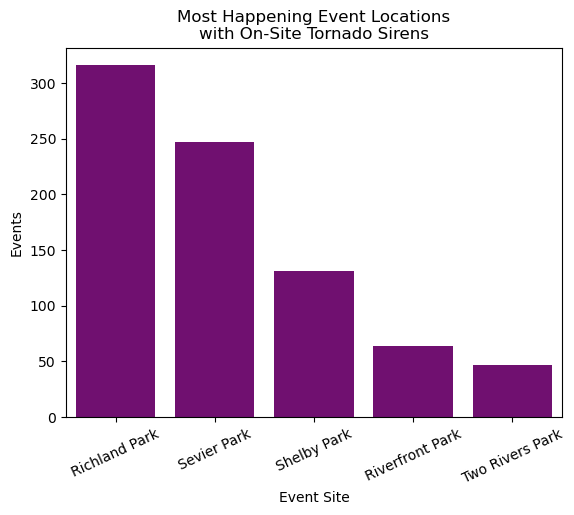

In [13]:
fig = sns.barplot(data=siren_event_df, x='event_site', y='events', color='purple')
fig.set(title='Most Happening Event Locations\nwith On-Site Tornado Sirens', xlabel='Event Site', ylabel='Events')
plt.xticks(rotation=25)

<hr>